<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/src/SYN/focus/tox_pol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [20]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

fatal: destination path 'thesis' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set up

In [21]:
# Choose settings for the parameters part
estimate_parameters=True # to estimate parameters
name_parameters='params_dict_trial_fb_1015' # good for ZIE separated

n=500 # number of threads
h=100 # number of hours considered

## Prepare Data

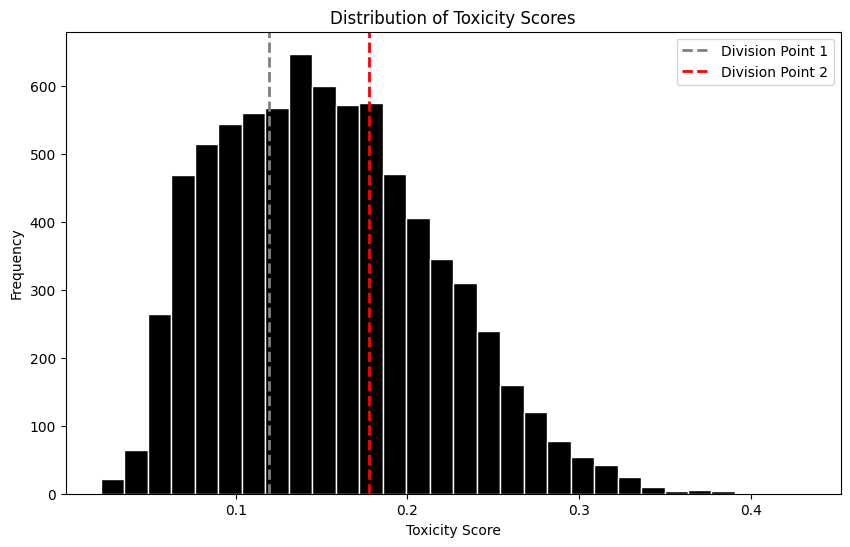

  0%|          | 0/3 [00:00<?, ?it/s]/content/thesis/src/SYN/SYN_package/estimate_parameters.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_comments_by_user_in_thread'].copy()
 33%|███▎      | 1/3 [00:05<00:10,  5.45s/it]/content/thesis/src/SYN/SYN_package/estimate_parameters.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_co

KS Test Results:
          polite     toxic    normal
polite       1.0  0.000027  0.002317
toxic   0.000027       1.0  0.273217
normal  0.002317  0.273217       1.0


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [40]:
platforms = ['reddit', 'voat', 'gab', 'facebook']
platforms = ['reddit']
for platform in platforms:
  if platform=='facebook':
    fb=pd.read_csv('/content/drive/MyDrive/thesis/data/'+platform+'/'+platform+'_news_PRO.csv')
  else:
    fb=pd.read_csv('/content/drive/MyDrive/thesis/data/'+platform+'/'+platform+'_PRO.csv')
  fb['year'] = pd.to_datetime(fb['thread_birth']).dt.year
  fb=filter_first_h(fb,h)

  fb['is_toxic']=fb['toxicity_score']>0.6
  toxicity_share_distribution=fb.groupby(['post_id'])['toxicity_score'].mean().reset_index()


  polite_post_ids=toxicity_share_distribution[
      (toxicity_share_distribution['toxicity_score'] < toxicity_share_distribution['toxicity_score'].quantile(0.15)) &
      (toxicity_share_distribution['toxicity_score'] > toxicity_share_distribution['toxicity_score'].quantile(0.05))
  ]['post_id']
  normal_post_ids = toxicity_share_distribution[
      (toxicity_share_distribution['toxicity_score'] < toxicity_share_distribution['toxicity_score'].quantile(0.55)) &
      (toxicity_share_distribution['toxicity_score'] > toxicity_share_distribution['toxicity_score'].quantile(0.45))
  ]['post_id']

  toxic_post_ids=toxicity_share_distribution[
      (toxicity_share_distribution['toxicity_score'] < toxicity_share_distribution['toxicity_score'].quantile(0.95)) &
      (toxicity_share_distribution['toxicity_score'] > toxicity_share_distribution['toxicity_score'].quantile(0.85))
  ]['post_id']

  import matplotlib.pyplot as plt
  import pandas as pd

  # Esempio di dati (da sostituire con i tuoi dati effettivi)
  # toxicity_share_distribution è il DataFrame, e 'toxicity_score' è la colonna di interesse
  toxicity_scores = toxicity_share_distribution['toxicity_score']

  # Creiamo l'istogramma
  plt.figure(figsize=(10, 6))
  plt.hist(toxicity_scores, bins=30, color='black', edgecolor='white')  # Modifica il numero di bins a seconda della distribuzione dei tuoi dati

  # Trova i quantili per dividere in tre parti uguali
  quantiles = toxicity_scores.quantile([0.33, 0.66])

  # Disegna le linee verticali per dividere l'istogramma
  plt.axvline(quantiles.iloc[0], color='gray', linestyle='--', linewidth=2, label='Division Point 1')
  plt.axvline(quantiles.iloc[1], color='red', linestyle='--', linewidth=2, label='Division Point 2')

  # Aggiungi legenda e etichette
  plt.legend()
  plt.xlabel('Toxicity Score')
  plt.ylabel('Frequency')
  plt.title('Distribution of Toxicity Scores')

  plt.show()


  toxic=fb[fb['post_id'].isin(toxic_post_ids)]

  toxic.groupby('post_id')['comment_id'].count().median()

  polite=fb[fb['post_id'].isin(polite_post_ids)]

  polite.groupby('post_id')['comment_id'].count().median()

  normal=fb[fb['post_id'].isin(normal_post_ids)]

  names=['toxic','normal','polite']
  datas=[toxic,normal,polite]


  params_dict = process_social_platform(names, datas)
  file_path = '/content/drive/MyDrive/thesis/data/parameters/'+'tox'+'.json'
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  with open(file_path, 'w') as file:
      json.dump(params_dict, file)

  df = pd.DataFrame.from_dict(params_dict, orient='index')
  df

  n=500
  time_intervals = np.arange(0, 1, 0.05)

  all_dfs = []
  for i, df in enumerate(datas):
      social = names[i]
      parameters = params_dict[social]
      datas_processed_s=[]
      datas_processed_o=[]
      names_processed=[]

      simulated_t, observed_t = simulate_data(df, parameters, activate_tqdm=True, num_threads=n)# peensaree a come limitar i valori dell funzionee IAT senza crear break infiniti
      globals()[f"{platform+'_'+social}s_M1"] = simulated_t
      globals()[f"{platform+'_'+social}o_M1"] = observed_t
      simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
      simulated_t_ECDF['Platform'] = social
      simulated_t_ECDF['Style'] = 'Simulated'

      observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
      observed_t_ECDF['Platform'] = social
      observed_t_ECDF['Style'] = 'Observed'

      df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
      all_dfs.append(df_platform)

  df_all_M1 = pd.concat(all_dfs, ignore_index=True)

  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  from scipy.stats import ks_2samp

  # Assuming df_all_M1 is your DataFrame containing the data
  # Filter and preprocess your data as needed
  df_all = df_all_M1.copy()
  df_all = df_all[df_all['Style'] == 'Observed']  # Assuming you want only the 'Observed' style
  df_all['Log_Share'] = np.log(df_all['Share'])  # Compute logarithm of Share

  # Define the styles for comparison and initialize an empty DataFrame for results
  styles = ['polite', 'toxic', 'normal']
  results = pd.DataFrame(index=styles, columns=styles)

  # Perform KS test for each pairwise combination of styles
  for i in range(len(styles)):
      for j in range(i, len(styles)):
          style1 = styles[i]
          style2 = styles[j]

          # Select data for the two styles
          data1 = df_all[df_all['Platform'] == style1]['Log_Share']
          data2 = df_all[df_all['Platform'] == style2]['Log_Share']

          # Perform KS test
          ks_statistic, p_value = ks_2samp(data1, data2)

          # Store p-value in the results DataFrame
          results.loc[style1, style2] = p_value
          results.loc[style2, style1] = p_value  # Since KS test is symmetric, store both ways

  # Display the results table
  print("KS Test Results:")
  print(results)


In [23]:
df = pd.DataFrame.from_dict(params_dict, orient='index')
df

,gamma,a,b,loc,scale,alpha,lambda,a_IAT,b_IAT,af_IAT,bf_IAT
toxic,1.788583,0.784508,229.822378,0.001,10.965986,0.945831,0.988980,0.028191,4.111809,0.042671,2.669147
normal,1.964815,0.593461,333.201417,0.001,12.526359,0.946816,0.988979,0.027917,3.763555,0.040179,2.295948
polite,2.016138,0.634015,146.600363,0.001,8.682498,0.974756,0.995515,0.036138,3.425740,0.031532,2.403400


In [ ]:
observed_t=[]
observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
observed_t_ECDF['Platform'] = social
observed_t_ECDF['Style'] = 'Observed'

df_platform = pd.concat([simulated_t_ECDF, ], ignore_index=True)

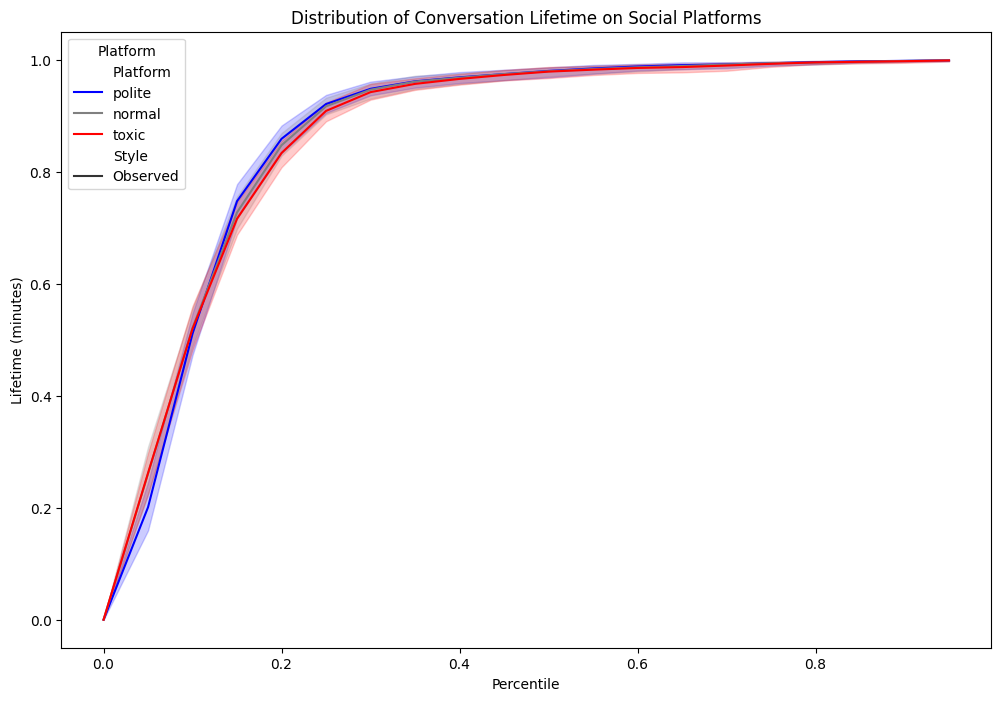

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_all_M1 is your DataFrame containing the data
df_all = df_all_M1.sort_values(by='Style')
df_all=df_all[df_all['Style']=='Observed']
df_all['Log_Share']=(df_all['Share'])**2
# Define colors based on Style categories
palette = {'polite': 'blue', 'toxic': 'red', 'normal': 'grey'}

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all, x='Time Grid Value', y='Log_Share', hue='Platform', style='Style', err_style='band', palette=palette, errorbar=('ci', 100))
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Assuming df_all_M1 is your DataFrame containing the data
# Filter and preprocess your data as needed
df_all = df_all_M1.copy()
df_all = df_all[df_all['Style'] == 'Observed']  # Assuming you want only the 'Observed' style
df_all['Log_Share']=(df_all['Share'])**2 # Compute logarithm of Share

# Define the styles for comparison and initialize an empty DataFrame for results
styles = ['polite', 'toxic', 'normal']
results = pd.DataFrame(index=styles, columns=styles)

# Perform KS test for each pairwise combination of styles
for i in range(len(styles)):
    for j in range(i, len(styles)):
        style1 = styles[i]
        style2 = styles[j]

        # Select data for the two styles
        data1 = df_all[df_all['Platform'] == style1]['Log_Share']
        data2 = df_all[df_all['Platform'] == style2]['Log_Share']

        # Perform KS test
        ks_statistic, p_value = ks_2samp(data1, data2)

        # Store p-value in the results DataFrame
        results.loc[style1, style2] = p_value
        results.loc[style2, style1] = p_value  # Since KS test is symmetric, store both ways

# Display the results table
print("KS Test Results:")
print(results)


KS Test Results:
         polite     toxic    normal
polite      1.0       0.0   0.00001
toxic       0.0       1.0  0.001602
normal  0.00001  0.001602       1.0


## Participation

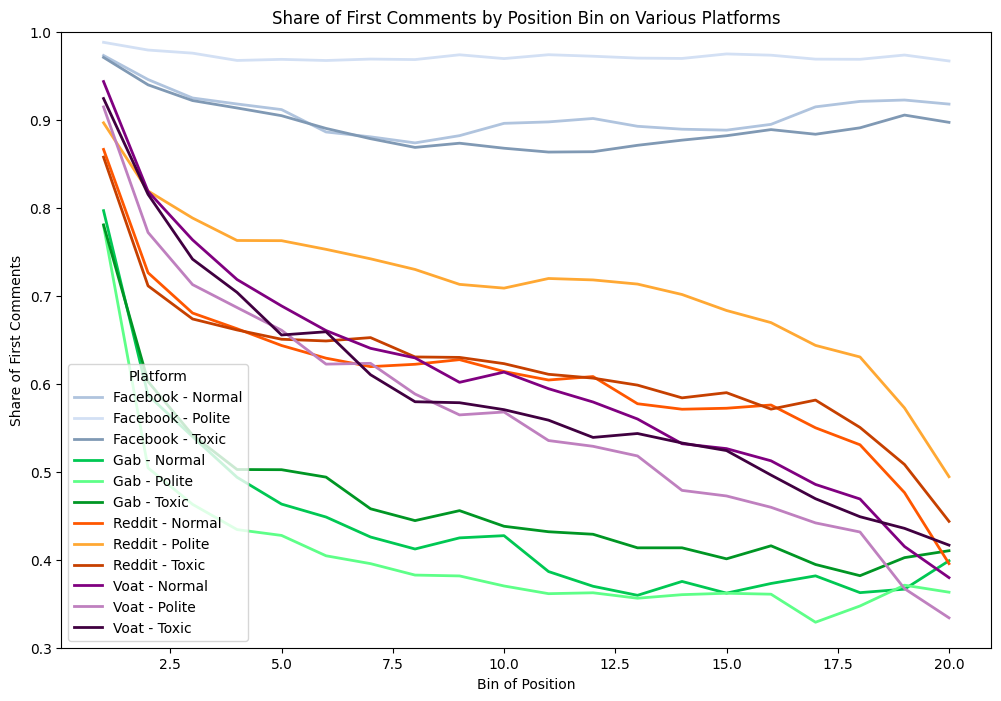

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

platforms = ['reddit', 'voat', 'gab', 'facebook']

all_platform_data = []

for platform in platforms:
    # Assuming politeo_M1, toxico_M1, normalo_M1 are your DataFrames
    polite = globals()[(platform)+'_'+'polite'+'o_M1']
    normal = globals()[platform+'_'+'normal'+'o_M1']
    toxic = globals()[platform+'_'+'toxic'+'o_M1']

    polite['Platform'] = platform.capitalize() + ' - Polite'
    toxic['Platform'] = platform.capitalize() + ' - Toxic'
    normal['Platform'] = platform.capitalize() + ' - Normal'

    # Combine all DataFrames into a single DataFrame for each platform
    platform_data = pd.concat([polite, toxic, normal], ignore_index=True)

    # Calculate additional features
    platform_data['number_of_comments'] = platform_data.groupby('post_id')['post_id'].transform('count')
    platform_data['sequential_position'] = platform_data.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    num_bins = 20
    platform_data['bin_of_position'] = ((platform_data['sequential_position'] - 1) / platform_data['number_of_comments'] * num_bins).astype(int) + 1
    platform_data['first_comment'] = platform_data['sequential_number_of_comment_by_user_in_thread'] == 1
    platform_data['first_comment'] = platform_data.groupby(['Platform', 'bin_of_position', 'post_id'])['first_comment'].transform('mean')

    all_platform_data.append(platform_data)

# Combine data across all platforms
all_data = pd.concat(all_platform_data, ignore_index=True)

# Aggregate data
agg_activity_obs = all_data.groupby(['Platform', 'bin_of_position'])['first_comment'].mean().reset_index()

# Define color palette
palette = {
    'Reddit - Polite': '#FFA833',   # Lighter shade of Reddit orange
    'Reddit - Toxic': '#C64000',    # Red for toxic
    'Reddit - Normal': '#FF5700',   # Reddit orange
    'Voat - Polite': '#BF80BF',     # Lavender for polite
    'Voat - Toxic': '#400040',      # Dark purple for toxic
    'Voat - Normal': '#800080',     # Voat purple
    'Gab - Polite': '#5eff88',      # Pale green for polite
    'Gab - Toxic': '#009624',       # Orange for toxic
    'Gab - Normal': '#00c853',      # Gab green
    'Facebook - Polite': '#D3E0F4', # Light steel blue for polite
    'Facebook - Toxic': '#8099B4',  # Saddle brown for toxic
    'Facebook - Normal': '#B0C4DE'  # Facebook blue
}

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='Platform',  # Different line for each platform
    estimator='mean',  # or 'sum', 'median', etc. depending on your aggregation preference
    err_style='band',  # Show error band
    errorbar=('ci', 100),  # Confidence interval
    palette=palette,
    linewidth=2
)
plt.title('Share of First Comments by Position Bin on Various Platforms')
plt.ylabel('Share of First Comments')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.ylim(0.3, 1)  # Adjust y-axis limits if needed
plt.legend(title='Platform')
plt.show()


,user_id,post_id,temporal_distance_birth_base_100h,sequential_number_of_comment_by_user_in_thread
0,User_0,3864786.0,0.085677,1
1,User_1,3864786.0,0.136310,1
2,User_1,3864786.0,0.417462,2
3,User_2,3864786.0,0.015222,1
4,User_3,3864786.0,0.147648,1
...,...,...,...,...
50946,User_53,341328.0,0.097858,1
50947,User_54,341328.0,0.055153,1
50948,User_55,341328.0,0.236400,1
50949,User_55,341328.0,0.236727,2


In [ ]:
for platform in platforms:
    if platform == 'facebook':
        fb = pd.read_csv('/content/drive/MyDrive/thesis/data/' + platform + '/' + platform + '_news_PRO.csv')
    else:
        fb = pd.read_csv('/content/drive/MyDrive/thesis/data/' + platform + '/' + platform + '_PRO.csv')

100%|██████████| 4/4 [00:55<00:00, 13.76s/it]


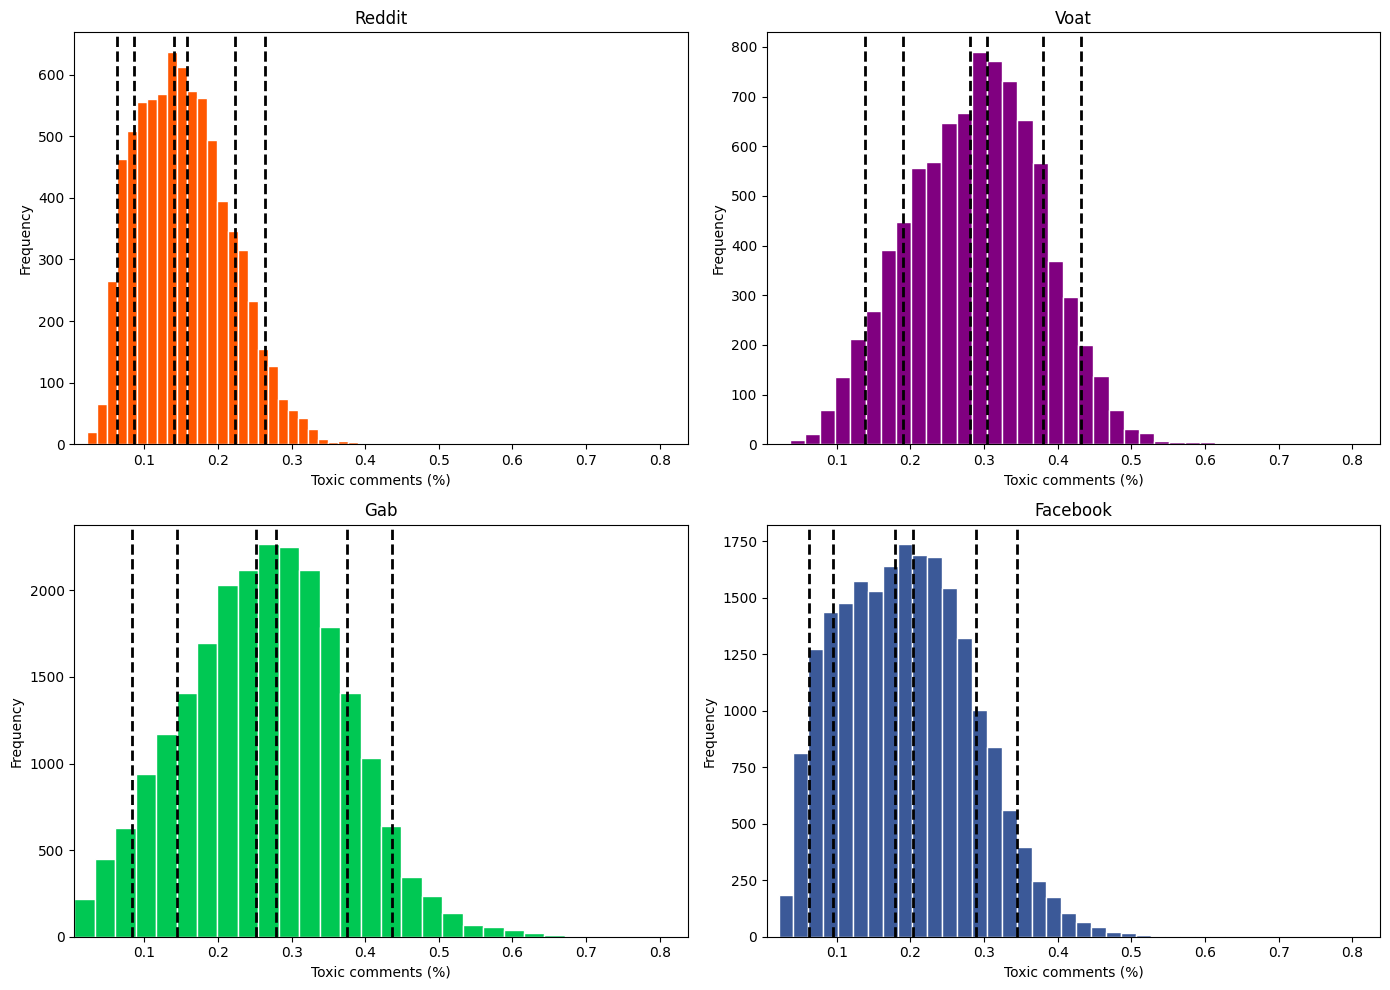

In [10]:


# Define platforms and colors
platforms = ['reddit', 'voat', 'gab', 'facebook']
palette = {
    'reddit': '#FF5700',   # Reddit orange
    'voat': '#800080',     # Voat purple
    'facebook': '#3b5998', # Facebook blue
    'gab': '#00c853'       # Gab green
}

# Set up the figure and axis
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

all_toxicity_scores = []

# Loop through each platform to gather toxicity scores for setting common xlim
for platform in platforms:
    if platform == 'facebook':
        fb = pd.read_csv('/content/drive/MyDrive/thesis/data/' + platform + '/' + platform + '_news_PRO.csv')
    else:
        fb = pd.read_csv('/content/drive/MyDrive/thesis/data/' + platform + '/' + platform + '_PRO.csv')

    fb['year'] = pd.to_datetime(fb['thread_birth']).dt.year
    fb['is_toxic'] = fb['toxicity_score'] > 0.6
    toxicity_share_distribution = fb.groupby(['post_id'])['toxicity_score'].mean().reset_index()
    toxicity_scores = toxicity_share_distribution['toxicity_score']
    all_toxicity_scores.append(toxicity_scores)

# Determine common x-axis limits
all_toxicity_scores_combined = pd.concat(all_toxicity_scores)
common_xlim = (all_toxicity_scores_combined.min(), all_toxicity_scores_combined.max())

# Plot each platform
for i, platform in tqdm(enumerate(platforms), total=4):
    if platform == 'facebook':
        fb = pd.read_csv('/content/drive/MyDrive/thesis/data/' + platform + '/' + platform + '_news_PRO.csv')
    else:
        fb = pd.read_csv('/content/drive/MyDrive/thesis/data/' + platform + '/' + platform + '_PRO.csv')

    fb['year'] = pd.to_datetime(fb['thread_birth']).dt.year
    fb['is_toxic'] = fb['toxicity_score'] > 0.6
    toxicity_share_distribution = fb.groupby(['post_id'])['toxicity_score'].mean().reset_index()
    toxicity_scores = toxicity_share_distribution['toxicity_score']

    # Create histogram
    axs[i].hist(toxicity_scores, bins=30, color=palette[platform], edgecolor='white')

    # Find quantiles for division
    quantiles = toxicity_scores.quantile([0.05, 0.15, 0.45, 0.55, 0.85, 0.95])

    # Draw vertical lines for quantiles
    for quantile in quantiles:
        axs[i].axvline(quantile, color='black', linestyle='--', linewidth=2)

    # Set labels, title, and xlim
    axs[i].set_xlim(common_xlim)
    axs[i].set_xlabel('Toxic comments (%)')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'{platform.capitalize()}')

# Adjust layout
plt.tight_layout()
plt.show()


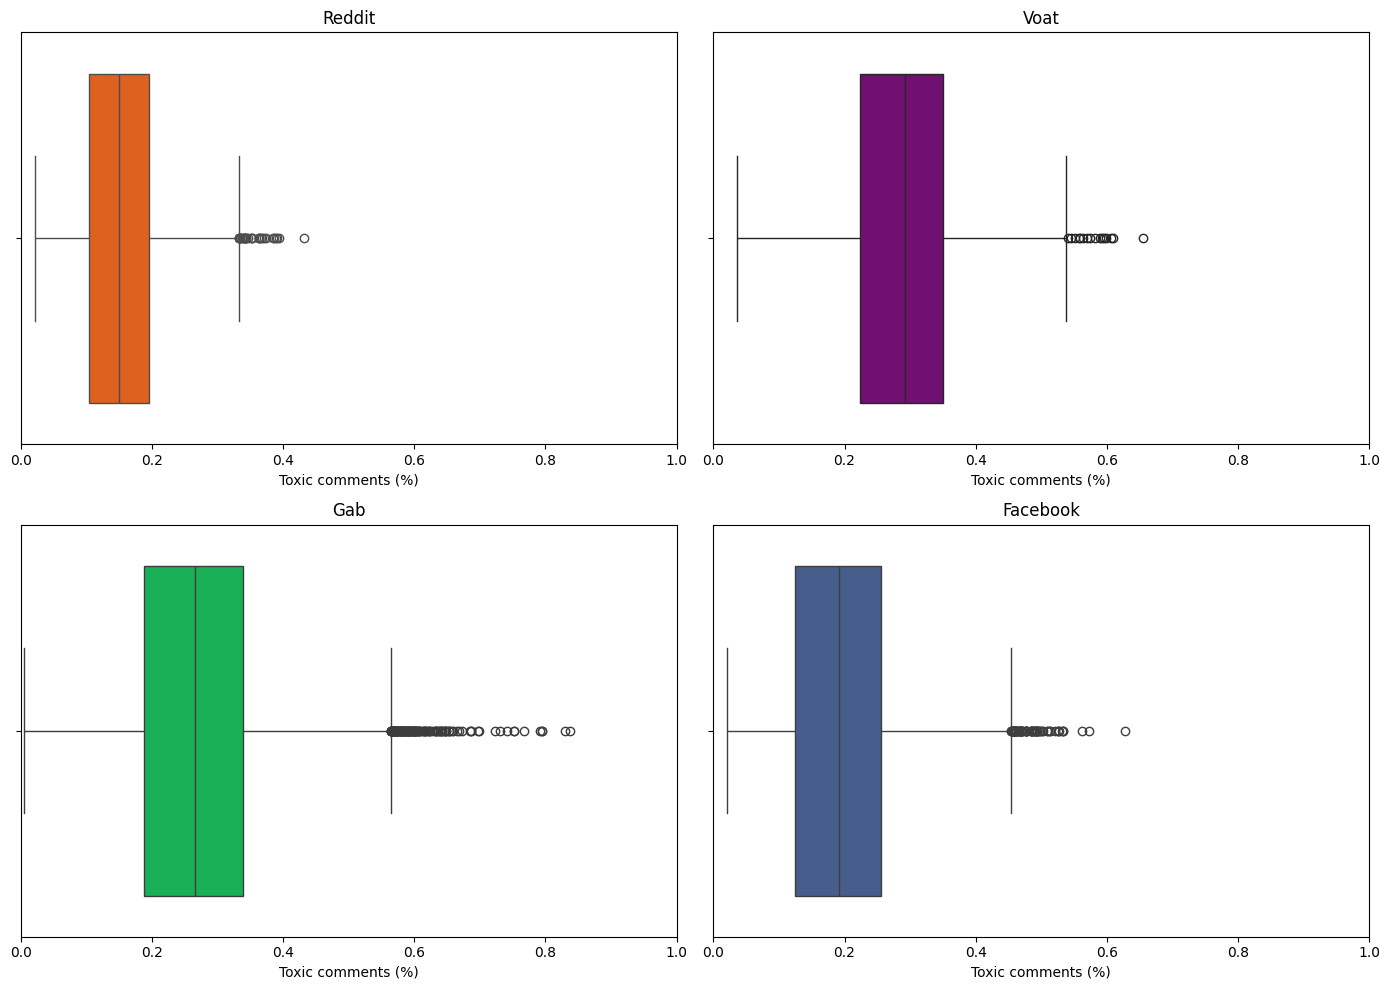

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define platforms and colors
platforms = ['reddit', 'voat', 'gab', 'facebook']
palette = {
    'reddit': '#FF5700',   # Reddit orange
    'voat': '#800080',     # Voat purple
    'facebook': '#3b5998', # Facebook blue
    'gab': '#00c853'       # Gab green
}

# Set up the figure and axis
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axs = axs.flatten()

all_toxicity_scores = []

# Loop through each platform to gather toxicity scores for setting common xlim
for platform in platforms:
    # Read data based on platform (adjust path as needed)
    if platform == 'facebook':
        fb = pd.read_csv('/content/drive/MyDrive/thesis/data/' + platform + '/' + platform + '_news_PRO.csv')
    else:
        fb = pd.read_csv('/content/drive/MyDrive/thesis/data/' + platform + '/' + platform + '_PRO.csv')

    # Process data
    fb['year'] = pd.to_datetime(fb['thread_birth']).dt.year
    fb['is_toxic'] = fb['toxicity_score'] > 0.6
    toxicity_share_distribution = fb.groupby(['post_id'])['toxicity_score'].mean().reset_index()
    toxicity_scores = toxicity_share_distribution['toxicity_score']
    all_toxicity_scores.append(toxicity_scores)

# Determine common x-axis limits
all_toxicity_scores_combined = pd.concat(all_toxicity_scores)
common_xlim = (0,1)

# Plot each platform
for i, platform in enumerate(platforms):
    # Read data based on platform (adjust path as needed)
    if platform == 'facebook':
        fb = pd.read_csv('/content/drive/MyDrive/thesis/data/' + platform + '/' + platform + '_news_PRO.csv')
    else:
        fb = pd.read_csv('/content/drive/MyDrive/thesis/data/' + platform + '/' + platform + '_PRO.csv')

    # Process data
    fb['year'] = pd.to_datetime(fb['thread_birth']).dt.year
    fb['is_toxic'] = fb['toxicity_score'] > 0.6
    toxicity_share_distribution = fb.groupby(['post_id'])['toxicity_score'].mean().reset_index()
    toxicity_scores = toxicity_share_distribution['toxicity_score']

    # Create box plot with common xlim
    sns.boxplot(x=toxicity_scores, ax=axs[i], color=palette[platform])

    # Set labels, title, and xlim
    axs[i].set_xlabel('Toxic comments (%)')
    axs[i].set_title(f'{platform.capitalize()}')
    axs[i].set_xlim(common_xlim)

# Adjust layout
plt.tight_layout()
plt.show()
